# Dubins trajectory interception

This notebook is about how to compute the minal time required for a Dubins vehicle to reach a target pose which is linearly drifting. This amount to optimal path planning under a continuous constant drift (sea current, wind for instance).

In this notebook, we will compute a crude lower bound by removing the turning aspect, transforming the problem into a point-mass interception.

For an upper bound, we will use the results of *[Rapid path planning for Dubins vehicles under environmental currents, 2020, Mittal et al.](https://doi.org/10.1016/j.robot.2020.103646)*

With these two bounds, we will be able to find an interval on which we can use local scalar optimisation, such as [Brent's method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brent.html).

## Lower-bound: Point-mass Interception of a linear trajectory

Let $P,D\in\mathbb{R}^2$ two points, respectively the one we command and a destination. Both move at constant speeds, $P$ at speed $v > 0$ and $D$ at speed $w > 0$ with direction $\beta\in[0,2\pi[$.

We want to find $\alpha\in[0,2\pi[$ the direction and $\tau > 0$ the time taken by $P$ to intercept $D$, assuming $v > w$.

Such values satisfy $$ P + \tau v\ e^{i\alpha} = D + \tau w\ e^{i \beta} $$

We rewrite this to 
$$ 
0 = R(-\beta) \Delta + \tau \left( 
\begin{matrix}
w - v \cos \delta \\
-v \sin \delta
\end{matrix}
\right)$$

With:

- $R(-\beta)\in\mathbb{R}^{2\times 2}$ the rotation matrix for the angle $-\beta$ (equivalent to multiplying by $e^{-i\beta}$)
- $\Delta := D - P\ $
- $\delta := \alpha - \beta$
- $[x\ y]^T := R(-\beta)\Delta$

We end up with the following system:
$$
\left\lbrace
\begin{matrix}
0 =& x + \tau (w - v \cos \delta)\\
0 =& y - \tau v \sin \delta
\end{matrix}
\right.
$$

If $\tau = 0$, then we get $x = y = 0$. Thus, we suppose $x \neq 0$ or $y \neq 0$. In that case:
$$
\left\lbrace
\begin{matrix}
\tau v \cos\delta \ =& x + \tau w\\
\sin\delta =& \cfrac{y}{\tau v}
\end{matrix}
\right.
$$

We can square both sides of the first equation then substitute $A$ using the second to achieve:
$$
\tau^2 v^2 \left(1 - \cfrac{y^2}{\tau^2 v^2}\right) = (x + \tau w)^2
$$

This simplifies into:
$$
\tau^2 (v^2 - w^2) -2 \tau w x - y^2 - x^2 = 0 
$$

In [1]:
tau = var('tau',domain='positive')
v = var('v',domain='positive')
w = var('w',domain='positive')
x = var('x',domain='real')
y = var('y',domain='real')

sols = solve(tau*tau*(v*v-w*w) - 2*tau*w*x - y*y - x*x == 0,tau,solution_dict=True)
show(sols)
tau_1 = sols[0][tau]
tau_2 = sols[1][tau]
show(tau_1)
show(tau_2)


[{tau: (w*x - sqrt(v^2*x^2 + (v^2 - w^2)*y^2))/(v^2 - w^2)},
 {tau: (w*x + sqrt(v^2*x^2 + (v^2 - w^2)*y^2))/(v^2 - w^2)}]

(w*x - sqrt(v^2*x^2 + (v^2 - w^2)*y^2))/(v^2 - w^2)

(w*x + sqrt(v^2*x^2 + (v^2 - w^2)*y^2))/(v^2 - w^2)

We get at most two solutions for $\tau$ from this quadratic. We keep only the smallest positive one. 

In [2]:
A_1 = y/(tau_1 * v)
A_2 = y/(tau_2 * v)

B_1 = (x + tau_1 * w)/(tau_1 * v)
B_2 = (x + tau_2 * w)/(tau_2 * v)

B_1 = B_1.expand().simplify().factor()
B_2 = B_2.expand().simplify().factor()

delta_1 = atan2(A_1,B_1)
delta_2 = atan2(A_2,B_2)

show(delta_1)
show(delta_2)

arctan2((v^2 - w^2)*y/((w*x - sqrt(v^2*x^2 + (v^2 - w^2)*y^2))*v), (v^2*x - sqrt(v^2*x^2 + (v^2 - w^2)*y^2)*w)/((w*x - sqrt(v^2*x^2 + (v^2 - w^2)*y^2))*v))

arctan2((v^2 - w^2)*y/((w*x + sqrt(v^2*x^2 + (v^2 - w^2)*y^2))*v), (v^2*x + sqrt(v^2*x^2 + (v^2 - w^2)*y^2)*w)/((w*x + sqrt(v^2*x^2 + (v^2 - w^2)*y^2))*v))

In [3]:
show((x + tau_1*(w-v*B_1)).expand().simplify().factor())
show((y - tau_1*v*A_1).expand().simplify().factor())
show((x + tau_2*(w-v*B_2)).expand().simplify().factor())
show((y - tau_2*v*A_2).expand().simplify().factor())

show((x + tau_1*(w-v*cos(delta_1))).expand().simplify().factor().simplify())
show((y - tau_1*v*sin(delta_1)).expand().simplify().factor())
show((x + tau_2*(w-v*cos(delta_2))).expand().simplify().factor())
show((y - tau_2*v*sin(delta_2)).expand().simplify().factor())

0

0

0

0

0

0

0

0

In [78]:
import numpy as np

def find_intersection(dx,dy,beta,v,w):
    x = np.cos(-beta)*dx - np.sin(-beta)*dy
    y = np.sin(-beta)*dx + np.cos(-beta)*dy

    if x == 0 and y == 0:
        return 0,0

    b = w*x
    denom = v*v-w*w
    discr = v*v*x*x+(v*v-w*w)*y*y

    if discr < 0:
        print("No solution: negative discriminant")
        return None,None

    tau_1 = (b - np.sqrt(discr))/denom
    tau_2 = (b + np.sqrt(discr))/denom

    tau = 0

    if tau_1 < 0 and tau_2 < 0:
        print("No solution: both negative")
        return None,None
    elif tau_1 < 0 and tau_2 > 0:
        tau = tau_2
    elif tau_1 > 0 and tau_2 < 0:
        tau = tau_1
    else:
        tau = min(tau_1,tau_2)

    A = y/(tau * v) # sin(delta)
    B = (x + tau * w)/(tau * v) # cos(delta)

    delta = np.arctan2(A,B)

    # Check solution
    assert abs(x + tau*(w-v*cos(delta))) < 1e-6
    assert abs(y - tau*v*sin(delta)) < 1e-6
    
    alpha = delta+beta

    # Check after rotation

    assert abs(dx + tau*(w*cos(beta) - v*cos(alpha))) < 1e-6
    assert abs(dy + tau*(w*sin(beta) - v*sin(alpha))) < 1e-6

    return tau,alpha




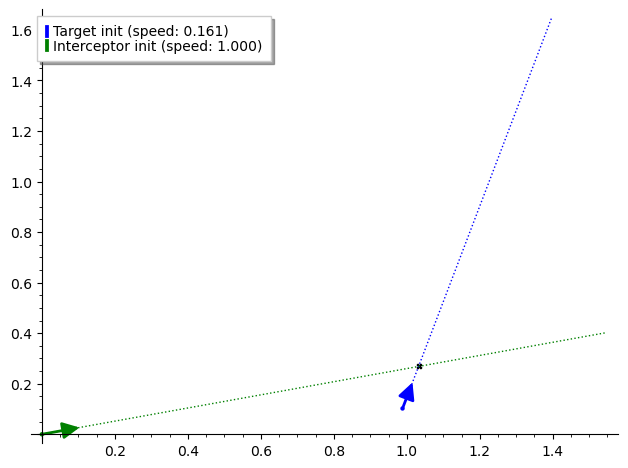

In [84]:
#np.random.seed(0)

dx = np.random.rand()
dy = np.random.rand()

beta = np.random.rand()*2*pi
v = 1
w = np.random.rand()*v

tau,alpha = find_intersection(dx,dy,beta,v,w)



start = point((0,0),marker='o',color='green')
target = np.array([dx,dy])
target_start = point((target[0],target[1]),marker='o',color='blue')

if tau is not None:
    dist = tau*v
else:
    dist = 1

target_arrow = arrow((dx,dy),(dx+dist*np.cos(beta)/10,dy+dist*np.sin(beta)/10),color='blue',legend_label=f"Target init (speed: {w:.3f})")
target_line = line([(dx,dy),(dx+dist*np.cos(beta)*1.5,dy+dist*np.sin(beta)*1.5)],color='blue',linestyle=':')

if tau is None or alpha is None:
    show(start+target_start+target_arrow+target_line)
    raise("No solution found")
    

target_vec = w*np.array([np.cos(beta) , np.sin(beta)])
interc_vec = v*np.array([np.cos(alpha), np.sin(alpha)])
arrival_pt = interc_vec*tau
arriva_pt_bis = target + target_vec*tau

try:
    assert(abs(np.linalg.norm(arrival_pt)/v - np.linalg.norm(arrival_pt-target)/w) < 1e-6)
except AssertionError:
    print("WARNING: Travel times do not match!!!")

try:
    assert(np.linalg.norm(arrival_pt-arriva_pt_bis) < 1e-6)
except AssertionError:
    print("WARNING: Interception point is inconsistent")


start_arrow = arrow((0,0),(dist*np.cos(alpha)/10, dist*np.sin(alpha)/10),color='green',legend_label=f"Interceptor init (speed: {v:.3f})")
start_line = line([(0,0),(dist*np.cos(alpha)*1.5,dist*np.sin(alpha)*1.5)],color='green',linestyle=':')

arrival = point((arrival_pt[0],arrival_pt[1]),marker='x',color='black')
arrival_bis = point((arriva_pt_bis[0],arriva_pt_bis[1]),marker='x',color='black')

show(start+target_start+target_arrow+target_line+start_arrow+start_line+arrival+arrival_bis)